# Soal 2: EDA Time Series - Uji Stasioneritas

## Assignment CLO 2 & 3 - Sistem Cerdas IoT

**Tujuan:** Mengecek apakah empat parameter cuaca bersifat **stasioner** atau tidak menggunakan metode **Augmented Dickey-Fuller (ADF) Test**.

**Parameter yang diuji:**
- TAVG (Temperatur rata-rata °C)
- RH_AVG (Kelembapan rata-rata %)
- RR (Curah hujan mm)
- FF_AVG (Kecepatan angin rata-rata m/s)

**Dataset:** Data hasil imputasi dari Soal 1 (2024_prophet.csv atau 2024_linear.csv)

## 1. Teori Stasioneritas

### Apa itu Stasioneritas?
Sebuah time series dikatakan **stasioner** jika properti statistiknya (mean, variance, autocorrelation) **tidak berubah seiring waktu**.

### Jenis Stasioneritas:
1. **Strict Stationarity**: Distribusi probabilitas tidak berubah seiring waktu
2. **Weak Stationarity**: Mean dan variance konstan, covariance hanya bergantung pada lag

### Augmented Dickey-Fuller (ADF) Test
- **Hipotesis Nol (H0)**: Data memiliki unit root (tidak stasioner)
- **Hipotesis Alternatif (H1)**: Data tidak memiliki unit root (stasioner)
- **Kriteria**: Jika **p-value < 0.05**, tolak H0 → Data **STASIONER**

## 2. Import Library

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

print("✅ Library berhasil diimport!")

✅ Library berhasil diimport!


## 3. Load Data Hasil Imputasi

Menggunakan data hasil imputasi Prophet dari Soal 1 (berdasarkan rekomendasi evaluasi performansi).

In [2]:
# Load data hasil imputasi Prophet
df = pd.read_csv('DATA/2024_prophet.csv', index_col='TANGGAL', parse_dates=True)

# Parameter yang akan diuji
params = ['TAVG', 'RH_AVG', 'RR', 'FF_AVG']

param_labels = {
    'TAVG': 'Temperatur Rata-rata (°C)',
    'RH_AVG': 'Kelembapan Rata-rata (%)',
    'RR': 'Curah Hujan (mm)',
    'FF_AVG': 'Kecepatan Angin Rata-rata (m/s)'
}

print("=" * 60)
print("DATA HASIL IMPUTASI PROPHET")
print("=" * 60)
print(f"Periode data: {df.index.min().strftime('%d-%m-%Y')} s.d. {df.index.max().strftime('%d-%m-%Y')}")
print(f"Jumlah data: {len(df)} hari")
print(f"\nStatistik Deskriptif:")
df[params].describe()

DATA HASIL IMPUTASI PROPHET
Periode data: 04-01-2024 s.d. 31-12-2024
Jumlah data: 363 hari

Statistik Deskriptif:


,TAVG,RH_AVG,RR,FF_AVG
count,363.000000,363.000000,363.000000,363.000000
mean,24.714397,77.099218,6.776562,0.523416
std,0.962750,7.806422,10.806633,0.557597
min,22.100000,49.000000,0.000000,0.000000
25%,24.100000,72.000000,0.000000,0.000000
50%,24.700000,77.000000,2.375852,0.000000
75%,25.400000,83.000000,9.000000,1.000000
max,27.100000,96.000000,63.400000,2.000000


## 4. Visualisasi Time Series

Sebelum melakukan uji stasioneritas, mari kita visualisasikan data time series untuk melihat pola secara visual.

✅ Plot disimpan ke: DATA/plot_rolling_statistics.png


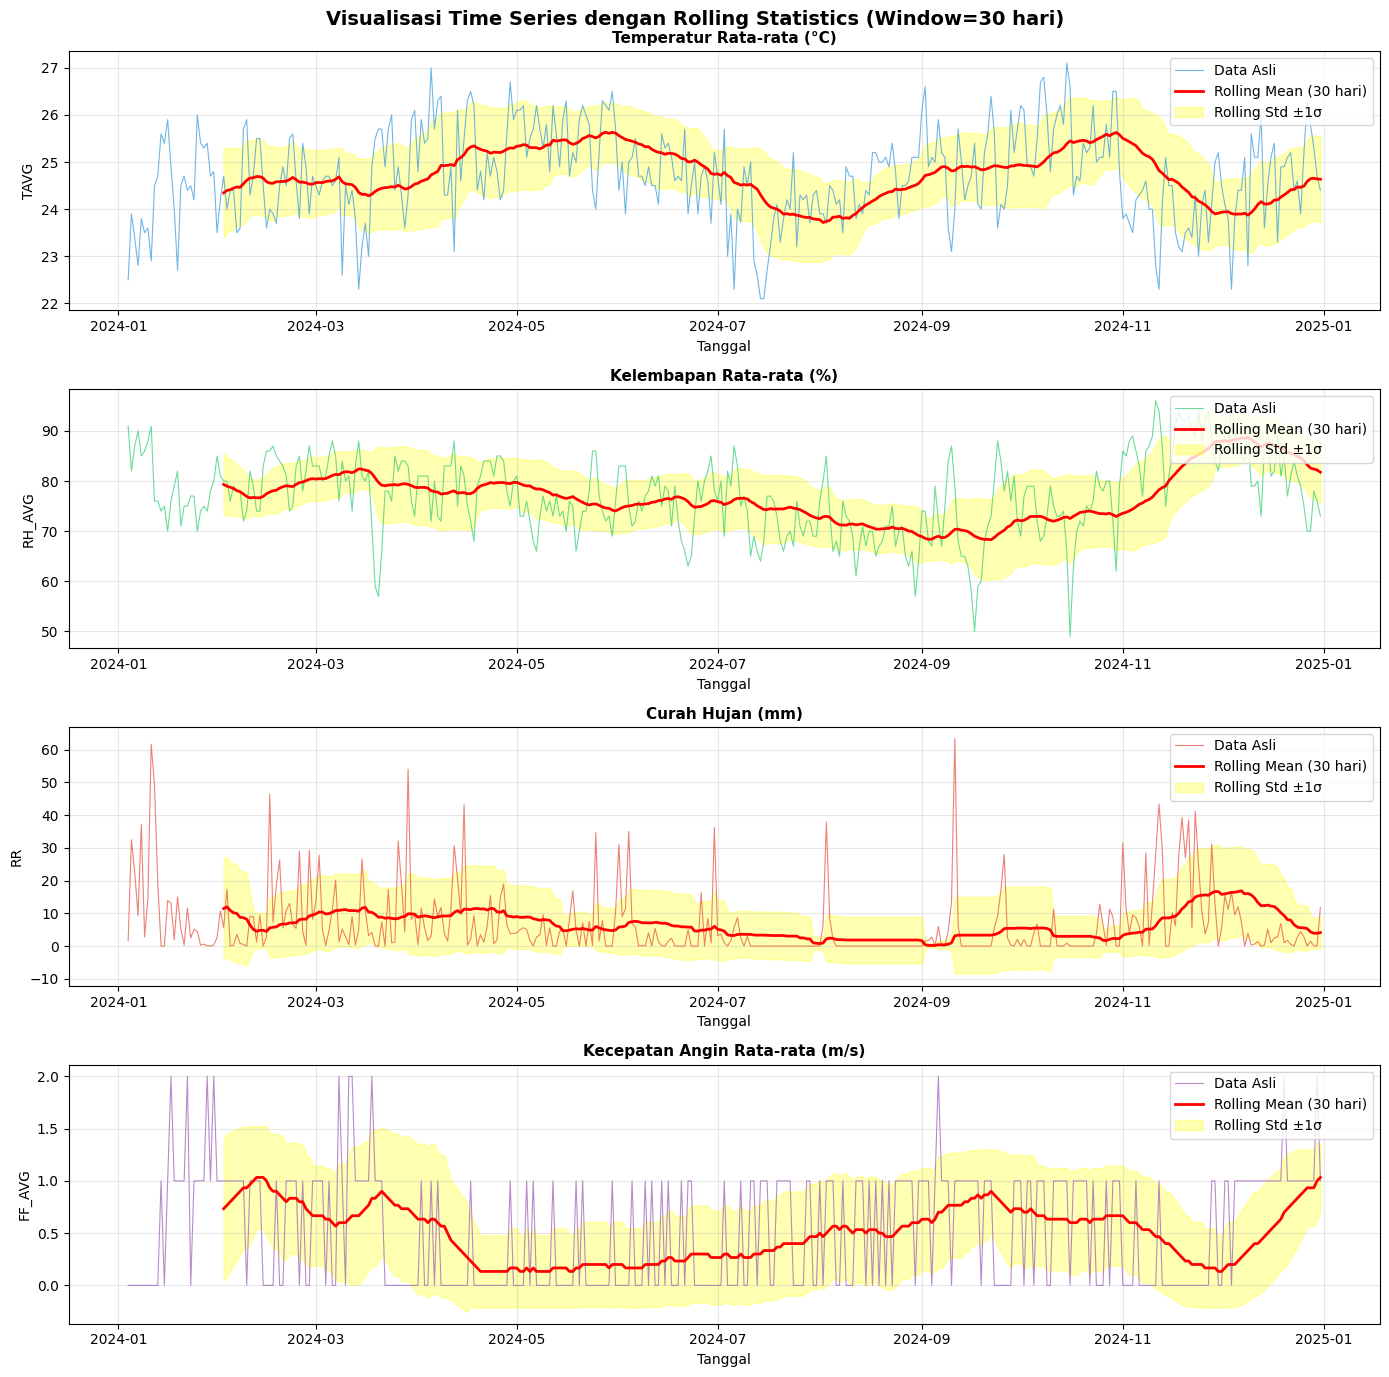

In [3]:
# Visualisasi Time Series dengan Rolling Mean dan Rolling Std
fig, axes = plt.subplots(4, 1, figsize=(14, 14))
fig.suptitle('Visualisasi Time Series dengan Rolling Statistics (Window=30 hari)', 
             fontsize=14, fontweight='bold')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for i, col in enumerate(params):
    ax = axes[i]
    
    # Plot data asli
    ax.plot(df.index, df[col], color=colors[i], alpha=0.7, linewidth=0.8, label='Data Asli')
    
    # Rolling Mean (30 hari)
    rolling_mean = df[col].rolling(window=30).mean()
    ax.plot(df.index, rolling_mean, color='red', linewidth=2, label='Rolling Mean (30 hari)')
    
    # Rolling Std (30 hari)
    rolling_std = df[col].rolling(window=30).std()
    ax.fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std, 
                    color='yellow', alpha=0.3, label='Rolling Std ±1σ')
    
    ax.set_title(f'{param_labels[col]}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Tanggal')
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('DATA/plot_rolling_statistics.png', dpi=150, bbox_inches='tight')
print("✅ Plot disimpan ke: DATA/plot_rolling_statistics.png")
plt.show()

## 5. Fungsi ADF Test

Membuat fungsi untuk melakukan Augmented Dickey-Fuller Test dan menampilkan hasilnya secara terstruktur.

In [4]:
def adf_test(series, name):
    """
    Melakukan Augmented Dickey-Fuller Test untuk uji stasioneritas
    
    Parameters:
    - series: pandas Series data time series
    - name: nama parameter untuk ditampilkan
    
    Returns:
    - dict: hasil ADF test
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    # Interpretasi hasil
    is_stationary = result[1] < 0.05
    status = "✅ STASIONER" if is_stationary else "❌ TIDAK STASIONER"
    
    output = {
        'Parameter': name,
        'ADF Statistic': round(result[0], 4),
        'p-value': round(result[1], 6),
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Value 1%': round(result[4]['1%'], 4),
        'Critical Value 5%': round(result[4]['5%'], 4),
        'Critical Value 10%': round(result[4]['10%'], 4),
        'Status': status,
        'is_stationary': is_stationary
    }
    
    return output

def print_adf_result(result):
    """
    Menampilkan hasil ADF test dengan format yang rapi
    """
    print(f"\n{'='*60}")
    print(f"📊 ADF TEST: {result['Parameter']}")
    print(f"{'='*60}")
    print(f"  ADF Statistic    : {result['ADF Statistic']}")
    print(f"  p-value          : {result['p-value']}")
    print(f"  Lags Used        : {result['Lags Used']}")
    print(f"  Observations     : {result['Observations']}")
    print(f"  Critical Values  :")
    print(f"    • 1%  : {result['Critical Value 1%']}")
    print(f"    • 5%  : {result['Critical Value 5%']}")
    print(f"    • 10% : {result['Critical Value 10%']}")
    print(f"\n  📌 Hasil: {result['Status']}")
    
    if result['is_stationary']:
        print(f"     → p-value ({result['p-value']}) < 0.05, tolak H0")
        print(f"     → Data tidak memiliki unit root (stasioner)")
    else:
        print(f"     → p-value ({result['p-value']}) >= 0.05, gagal tolak H0")
        print(f"     → Data memiliki unit root (tidak stasioner)")

print("✅ Fungsi ADF Test berhasil dibuat!")

✅ Fungsi ADF Test berhasil dibuat!


## 6. Uji Stasioneritas ADF untuk Setiap Parameter

Melakukan ADF Test untuk keempat parameter cuaca: TAVG, RH_AVG, RR, dan FF_AVG.

In [5]:
# Lakukan ADF Test untuk setiap parameter
print("=" * 70)
print("HASIL UJI STASIONERITAS DENGAN AUGMENTED DICKEY-FULLER (ADF) TEST")
print("=" * 70)

adf_results = []

for col in params:
    result = adf_test(df[col], param_labels[col])
    adf_results.append(result)
    print_adf_result(result)

HASIL UJI STASIONERITAS DENGAN AUGMENTED DICKEY-FULLER (ADF) TEST

📊 ADF TEST: Temperatur Rata-rata (°C)
  ADF Statistic    : -2.3707
  p-value          : 0.15018
  Lags Used        : 15
  Observations     : 347
  Critical Values  :
    • 1%  : -3.4493
    • 5%  : -2.8699
    • 10% : -2.5712

  📌 Hasil: ❌ TIDAK STASIONER
     → p-value (0.15018) >= 0.05, gagal tolak H0
     → Data memiliki unit root (tidak stasioner)

📊 ADF TEST: Kelembapan Rata-rata (%)
  ADF Statistic    : -4.0129
  p-value          : 0.001344
  Lags Used        : 6
  Observations     : 356
  Critical Values  :
    • 1%  : -3.4489
    • 5%  : -2.8697
    • 10% : -2.5711

  📌 Hasil: ✅ STASIONER
     → p-value (0.001344) < 0.05, tolak H0
     → Data tidak memiliki unit root (stasioner)

📊 ADF TEST: Curah Hujan (mm)
  ADF Statistic    : -7.5077
  p-value          : 0.0
  Lags Used        : 2
  Observations     : 360
  Critical Values  :
    • 1%  : -3.4486
    • 5%  : -2.8696
    • 10% : -2.5711

  📌 Hasil: ✅ STASIONER


## 7. Ringkasan Hasil ADF Test

Tabel ringkasan hasil uji stasioneritas untuk semua parameter.


RINGKASAN HASIL UJI STASIONERITAS ADF
                      Parameter  ADF Statistic  p-value  Critical Value 5%            Status
      Temperatur Rata-rata (°C)        -2.3707 0.150180            -2.8699 ❌ TIDAK STASIONER
       Kelembapan Rata-rata (%)        -4.0129 0.001344            -2.8697       ✅ STASIONER
               Curah Hujan (mm)        -7.5077 0.000000            -2.8696       ✅ STASIONER
Kecepatan Angin Rata-rata (m/s)        -3.2464 0.017450            -2.8697       ✅ STASIONER

✅ Plot disimpan ke: DATA/plot_adf_comparison.png


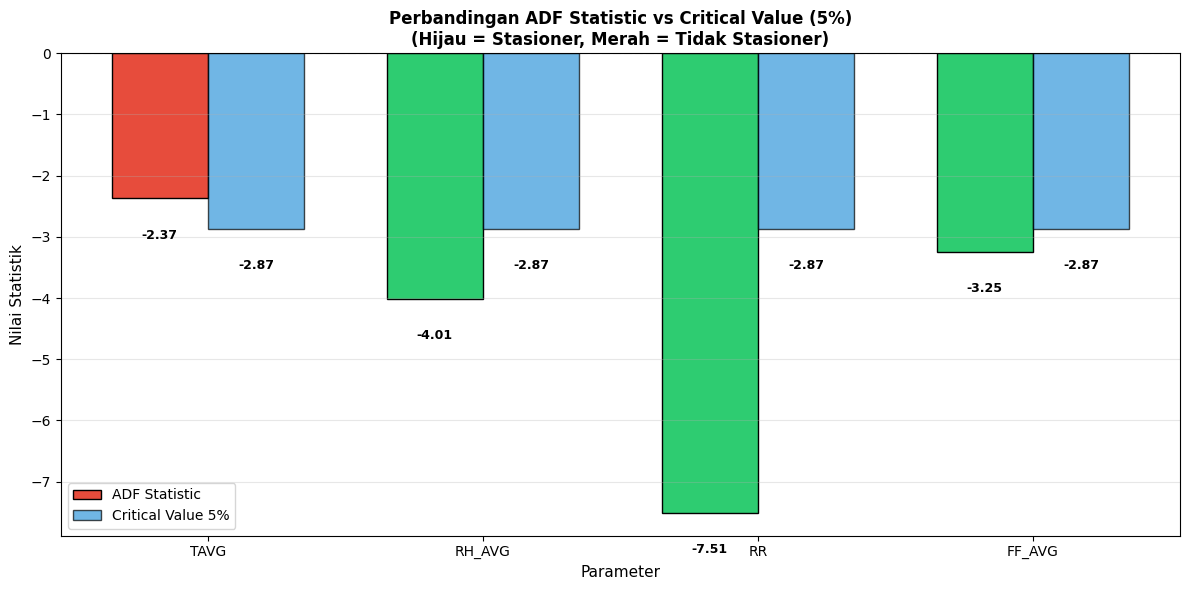

In [6]:
# Buat DataFrame ringkasan
summary_df = pd.DataFrame(adf_results)[['Parameter', 'ADF Statistic', 'p-value', 
                                         'Critical Value 5%', 'Status']]

print("\n" + "=" * 80)
print("RINGKASAN HASIL UJI STASIONERITAS ADF")
print("=" * 80)
print(summary_df.to_string(index=False))

# Visualisasi hasil
fig, ax = plt.subplots(figsize=(12, 6))

# Data untuk bar chart
params_short = ['TAVG', 'RH_AVG', 'RR', 'FF_AVG']
adf_stats = [r['ADF Statistic'] for r in adf_results]
critical_5 = [r['Critical Value 5%'] for r in adf_results]
is_stationary = [r['is_stationary'] for r in adf_results]

x = np.arange(len(params_short))
width = 0.35

# Bar untuk ADF Statistic
colors_bar = ['#2ecc71' if s else '#e74c3c' for s in is_stationary]
bars1 = ax.bar(x - width/2, adf_stats, width, label='ADF Statistic', color=colors_bar, edgecolor='black')

# Bar untuk Critical Value 5%
bars2 = ax.bar(x + width/2, critical_5, width, label='Critical Value 5%', color='#3498db', alpha=0.7, edgecolor='black')

# Garis threshold
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Parameter', fontsize=11)
ax.set_ylabel('Nilai Statistik', fontsize=11)
ax.set_title('Perbandingan ADF Statistic vs Critical Value (5%)\n(Hijau = Stasioner, Merah = Tidak Stasioner)', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(params_short)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Tambahkan label nilai
for i, (adf, crit) in enumerate(zip(adf_stats, critical_5)):
    ax.text(i - width/2, adf - 0.5, f'{adf:.2f}', ha='center', va='top', fontweight='bold', fontsize=9)
    ax.text(i + width/2, crit - 0.5, f'{crit:.2f}', ha='center', va='top', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('DATA/plot_adf_comparison.png', dpi=150, bbox_inches='tight')
print("\n✅ Plot disimpan ke: DATA/plot_adf_comparison.png")
plt.show()

## 8. Visualisasi ACF dan PACF

**ACF (Autocorrelation Function)** dan **PACF (Partial Autocorrelation Function)** membantu mengidentifikasi pola autokorelasi dalam data time series.

- **ACF**: Mengukur korelasi antara nilai pada waktu t dengan nilai pada waktu t-k
- **PACF**: Mengukur korelasi parsial setelah menghilangkan efek lag sebelumnya

✅ Plot ACF/PACF disimpan ke: DATA/plot_acf_pacf.png


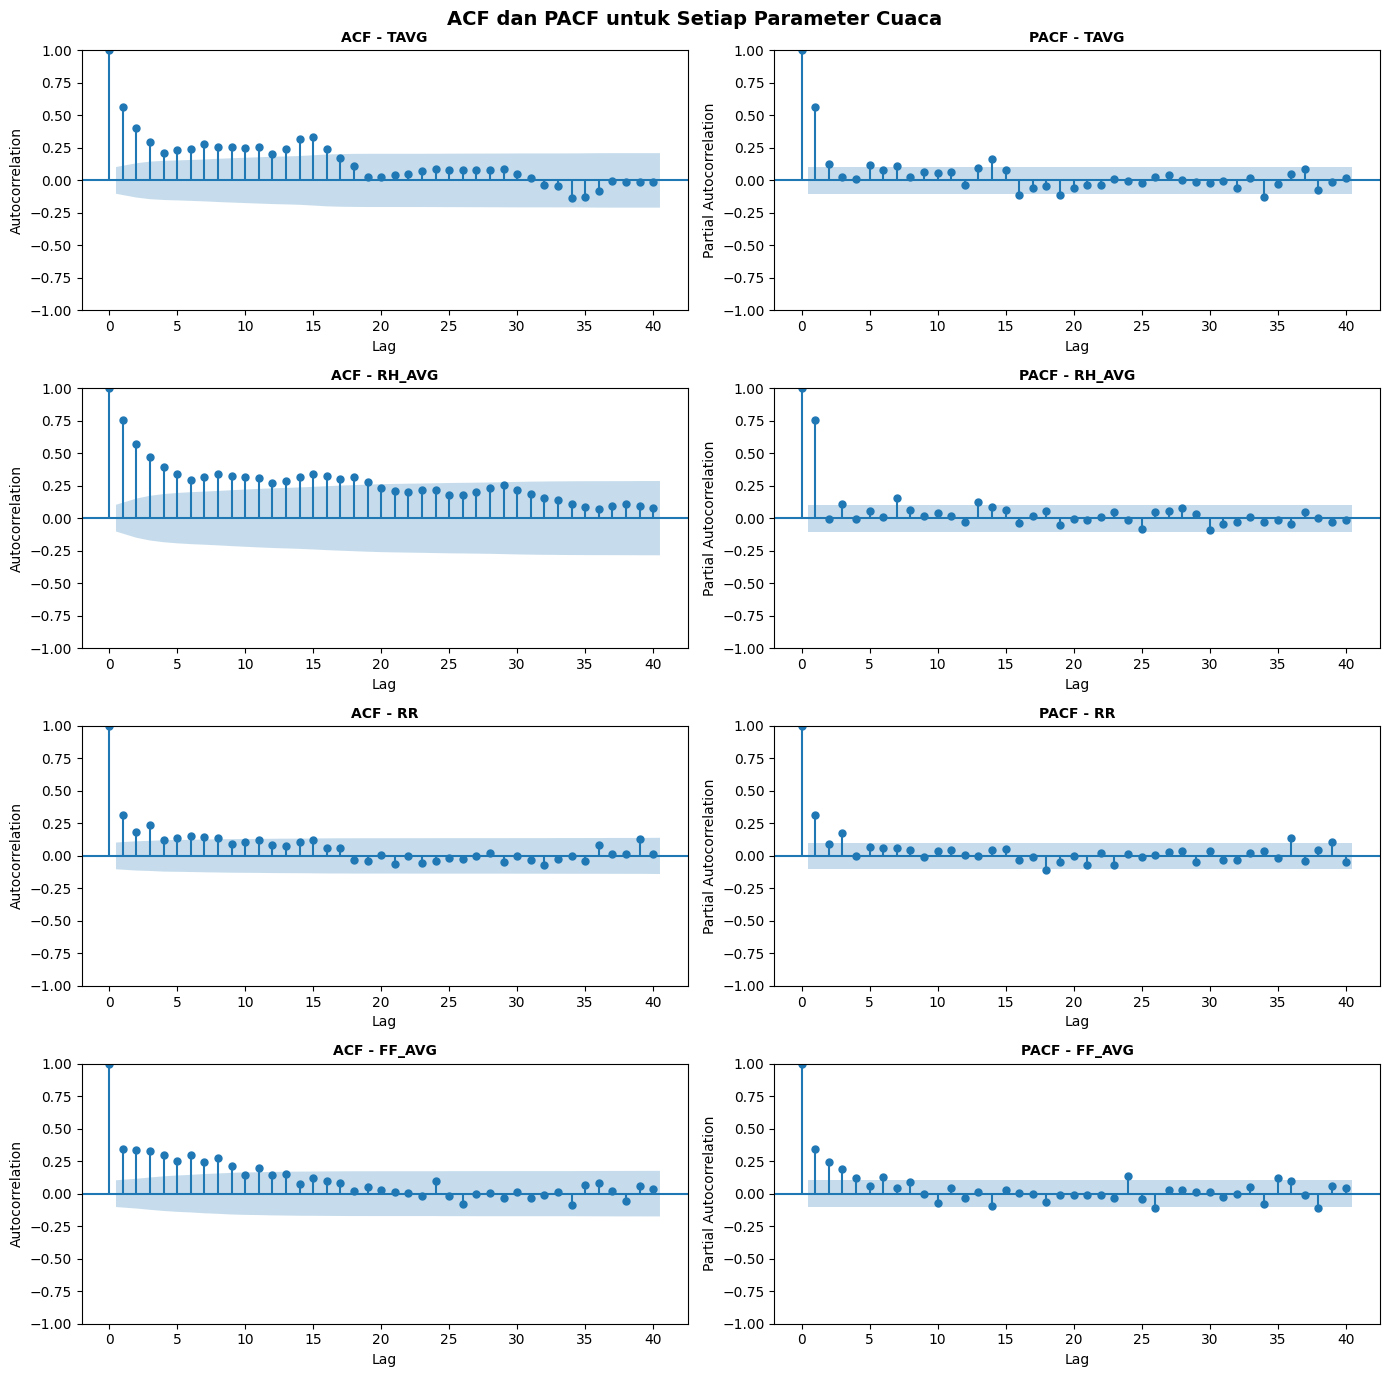

In [7]:
# Plot ACF dan PACF untuk setiap parameter
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
fig.suptitle('ACF dan PACF untuk Setiap Parameter Cuaca', fontsize=14, fontweight='bold')

for i, col in enumerate(params):
    # ACF
    plot_acf(df[col].dropna(), ax=axes[i, 0], lags=40, alpha=0.05)
    axes[i, 0].set_title(f'ACF - {col}', fontsize=10, fontweight='bold')
    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Autocorrelation')
    
    # PACF
    plot_pacf(df[col].dropna(), ax=axes[i, 1], lags=40, alpha=0.05)
    axes[i, 1].set_title(f'PACF - {col}', fontsize=10, fontweight='bold')
    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('DATA/plot_acf_pacf.png', dpi=150, bbox_inches='tight')
print("✅ Plot ACF/PACF disimpan ke: DATA/plot_acf_pacf.png")
plt.show()

## 9. Kesimpulan dan Interpretasi

In [8]:
# Kesimpulan
print("=" * 80)
print("KESIMPULAN UJI STASIONERITAS ADF")
print("=" * 80)

stationary_count = sum([r['is_stationary'] for r in adf_results])
non_stationary_count = len(adf_results) - stationary_count

print(f"\n📊 RINGKASAN:")
print(f"   • Parameter Stasioner     : {stationary_count} dari {len(adf_results)}")
print(f"   • Parameter Tidak Stasioner: {non_stationary_count} dari {len(adf_results)}")

print(f"\n📌 DETAIL HASIL:")
print("-" * 80)
for r in adf_results:
    status_emoji = "✅" if r['is_stationary'] else "❌"
    print(f"   {status_emoji} {r['Parameter'][:30]:30s} : {r['Status']}")
    print(f"      ADF Statistic: {r['ADF Statistic']:.4f}, p-value: {r['p-value']:.6f}")

print("\n" + "=" * 80)
print("INTERPRETASI:")
print("=" * 80)
print("""
📖 CARA MEMBACA HASIL ADF TEST:

1. KRITERIA STASIONERITAS:
   • Jika p-value < 0.05 → Data STASIONER (tolak H0)
   • Jika p-value ≥ 0.05 → Data TIDAK STASIONER (gagal tolak H0)
   
   Alternatif: Bandingkan ADF Statistic dengan Critical Value
   • Jika ADF Statistic < Critical Value (lebih negatif) → STASIONER

2. IMPLIKASI HASIL:
   
   📈 DATA STASIONER:
   • Mean dan variance konstan sepanjang waktu
   • Cocok untuk analisis time series langsung
   • Dapat digunakan untuk forecasting tanpa transformasi
   
   📉 DATA TIDAK STASIONER:
   • Memiliki trend atau seasonality yang kuat
   • Perlu dilakukan differencing atau transformasi
   • Contoh transformasi: First Difference (Yt - Yt-1)

3. UNTUK DATA CUACA:
   • Data cuaca harian seringkali STASIONER karena fluktuasi
     yang relatif konstan (tidak ada trend jangka panjang)
   • Namun bisa juga NON-STASIONER jika ada perubahan iklim
     atau pola musiman yang sangat kuat
""")

print("=" * 80)
print("FILE OUTPUT YANG DIHASILKAN:")
print("=" * 80)
print("  📁 DATA/plot_rolling_statistics.png - Visualisasi Rolling Mean/Std")
print("  📁 DATA/plot_adf_comparison.png     - Perbandingan ADF vs Critical Value")
print("  📁 DATA/plot_acf_pacf.png           - Plot ACF dan PACF")
print("\n✅ SOAL 2 SELESAI!")

KESIMPULAN UJI STASIONERITAS ADF

📊 RINGKASAN:
   • Parameter Stasioner     : 3 dari 4
   • Parameter Tidak Stasioner: 1 dari 4

📌 DETAIL HASIL:
--------------------------------------------------------------------------------
   ❌ Temperatur Rata-rata (°C)      : ❌ TIDAK STASIONER
      ADF Statistic: -2.3707, p-value: 0.150180
   ✅ Kelembapan Rata-rata (%)       : ✅ STASIONER
      ADF Statistic: -4.0129, p-value: 0.001344
   ✅ Curah Hujan (mm)               : ✅ STASIONER
      ADF Statistic: -7.5077, p-value: 0.000000
   ✅ Kecepatan Angin Rata-rata (m/s : ✅ STASIONER
      ADF Statistic: -3.2464, p-value: 0.017450

INTERPRETASI:

📖 CARA MEMBACA HASIL ADF TEST:

1. KRITERIA STASIONERITAS:
   • Jika p-value < 0.05 → Data STASIONER (tolak H0)
   • Jika p-value ≥ 0.05 → Data TIDAK STASIONER (gagal tolak H0)

   Alternatif: Bandingkan ADF Statistic dengan Critical Value
   • Jika ADF Statistic < Critical Value (lebih negatif) → STASIONER

2. IMPLIKASI HASIL:

   📈 DATA STASIONER:
   • Mea